# Imports and configs

In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

# Loading OOF files

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [4]:
def get_data(oof_path, test_oof_path):
    oof_pred_probs = pickle.load(open(oof_path, 'rb'))
    test_pred_probs = pickle.load(open(test_oof_path, 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [5]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [6]:
oof_paths = glob.glob(f'{CFG.oof_path}/oof_pred_probs/**')
test_oof_paths = glob.glob(f'{CFG.oof_path}/test_pred_probs/**')
for oof_path, test_oof_path in zip(oof_paths, test_oof_paths):
    model_name = oof_path.split('/')[-1][:-28]
    if "L1" in model_name and "PSEUDO" not in model_name:
        oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(oof_path, test_oof_path)

# L2 Logistic Regression

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            iters = model.n_iter_
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}' + ('' if isinstance(self.model, Ridge) else f' ({iters[0]} iterations)'))
            
        overall_score = roc_auc_score(y, oof_pred_probs)
        
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')   
        
        return oof_pred_probs, test_pred_probs, scores
    
    def fit(self, X, y):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)

In [8]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [9]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [10]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [11]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'max_iter': 1000,
        'C': trial.suggest_float('C', 0, 1),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2)
    }
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)
lr_params = study.best_params

[I 2024-10-09 01:02:50,958] A new study created in memory with name: no-name-ed1348f9-e72f-4d91-b4f3-7df93b0ab53d
[I 2024-10-09 01:03:27,271] Trial 1 finished with value: 0.9600781020720264 and parameters: {'C': 0.15450745087767692, 'tol': 0.0056600838370640776}. Best is trial 1 with value: 0.9600781020720264.
[I 2024-10-09 01:03:30,290] Trial 2 finished with value: 0.9600558620307847 and parameters: {'C': 0.29119937639939486, 'tol': 0.006511569273531758}. Best is trial 1 with value: 0.9600781020720264.
[I 2024-10-09 01:03:30,966] Trial 3 finished with value: 0.9600373127886785 and parameters: {'C': 0.9545806088062578, 'tol': 0.0038228999849710473}. Best is trial 1 with value: 0.9600781020720264.
[I 2024-10-09 01:03:33,624] Trial 0 finished with value: 0.9600351459324118 and parameters: {'C': 0.9818895758564342, 'tol': 0.00015805198781840252}. Best is trial 1 with value: 0.9600781020720264.
[I 2024-10-09 01:04:08,051] Trial 4 finished with value: 0.9600425989655047 and parameters: {'C'

In [12]:
print(lr_params)

{'C': 0.027169042312314064, 'tol': 0.006370195977287626}


In [13]:
lr_model = LogisticRegression(random_state=CFG.seed, max_iter=1000, **lr_params)
lr_trainer = Trainer(lr_model)
l2_oof_pred_probs['LR_Ensemble_L2'], l2_test_pred_probs['LR_Ensemble_L2'], scores['LR_Ensemble_L2'] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.963260 (130 iterations)
--- Fold 2 - AUC: 0.959733 (147 iterations)
--- Fold 3 - AUC: 0.959306 (166 iterations)
--- Fold 4 - AUC: 0.958886 (132 iterations)
--- Fold 5 - AUC: 0.959493 (143 iterations)

------ Overall: 0.960130 | Average: 0.960136 ± 0.001587


In [14]:
save_submission('lr-ensemble-l2', l2_test_pred_probs['LR_Ensemble_L2'], np.mean(scores['LR_Ensemble_L2']))

,id,loan_status
0,58645,0.997095
1,58646,0.013779
2,58647,0.571098
3,58648,0.013068
4,58649,0.053003


# L2 Ridge

In [15]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [16]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2),
        'positive': trial.suggest_categorical('positive', [True, False])
    }
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)
ridge_params = study.best_params

[I 2024-10-09 02:05:58,505] A new study created in memory with name: no-name-d3c2dcf4-988f-4ba8-8f74-38a91238caf3
[I 2024-10-09 02:06:01,021] Trial 0 finished with value: 0.959455797620387 and parameters: {'alpha': 13.358100637127773, 'tol': 0.008487501075501249, 'positive': False}. Best is trial 0 with value: 0.959455797620387.
[I 2024-10-09 02:06:01,234] Trial 3 finished with value: 0.9593768502363004 and parameters: {'alpha': 6.090171218419127, 'tol': 0.00839436950188741, 'positive': False}. Best is trial 0 with value: 0.959455797620387.
[I 2024-10-09 02:06:01,422] Trial 1 finished with value: 0.9594750016816949 and parameters: {'alpha': 39.694674906544186, 'tol': 0.003036701114800892, 'positive': False}. Best is trial 1 with value: 0.9594750016816949.
[I 2024-10-09 02:06:02,320] Trial 2 finished with value: 0.9580034086315885 and parameters: {'alpha': 3.4302808327959786, 'tol': 0.008084541354495729, 'positive': True}. Best is trial 1 with value: 0.9594750016816949.
[I 2024-10-09 02

In [17]:
print(ridge_params)

{'alpha': 26.986344006929183, 'tol': 0.008189536955568514, 'positive': False}


In [18]:
ridge_model = Ridge(random_state=CFG.seed, **ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_pred_probs['Ridge_Ensemble_L2'], l2_test_pred_probs['Ridge_Ensemble_L2'], scores['Ridge_Ensemble_L2'] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - AUC: 0.961879
--- Fold 2 - AUC: 0.959385
--- Fold 3 - AUC: 0.959257
--- Fold 4 - AUC: 0.958520
--- Fold 5 - AUC: 0.958380

------ Overall: 0.959473 | Average: 0.959484 ± 0.001260


In [19]:
save_submission('ridge-ensemble-l2', l2_test_pred_probs['Ridge_Ensemble_L2'], np.mean(scores['Ridge_Ensemble_L2']))

,id,loan_status
0,58645,0.998749
1,58646,0.024782
2,58647,0.548510
3,58648,0.012214
4,58649,0.066047


# L3 weighted ensemble

In [20]:
def objective(trial):
    weights = [trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()]
    weights /= np.sum(weights)
    weights = [round(w, 3) for w in weights]
    
    preds = np.zeros(X.shape[0])
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
    
    return roc_auc_score(y.values, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, n_jobs=-1)

[I 2024-10-09 02:12:15,427] A new study created in memory with name: no-name-4dee5727-33da-44ce-80d1-19298827541d
[I 2024-10-09 02:12:15,473] Trial 0 finished with value: 0.9600750922848607 and parameters: {'LR_Ensemble_L2': 0.45547782566830497, 'Ridge_Ensemble_L2': 0.5512268134736814}. Best is trial 0 with value: 0.9600750922848607.
[I 2024-10-09 02:12:15,474] Trial 2 finished with value: 0.9601995626998315 and parameters: {'LR_Ensemble_L2': 0.7885010011954593, 'Ridge_Ensemble_L2': 0.37274420691983134}. Best is trial 2 with value: 0.9601995626998315.
[I 2024-10-09 02:12:15,475] Trial 3 finished with value: 0.960122172594864 and parameters: {'LR_Ensemble_L2': 0.58166115856541, 'Ridge_Ensemble_L2': 0.5550741225977087}. Best is trial 2 with value: 0.9601995626998315.
[I 2024-10-09 02:12:15,476] Trial 1 finished with value: 0.9601927859163868 and parameters: {'LR_Ensemble_L2': 0.8595111394771096, 'Ridge_Ensemble_L2': 0.4574709269637297}. Best is trial 2 with value: 0.9601995626998315.
[I 

In [21]:
scores['Weighted_Ensemble_L3'] = [study.best_value] * CFG.n_folds

In [22]:
best_weights = study.best_params
best_weights = [best_weights[l2_model] for l2_model in l2_oof_pred_probs.keys()]
best_weights /= np.sum(best_weights)
best_weights = [round(w, 3) for w in best_weights]
print(best_weights)

[0.764, 0.236]


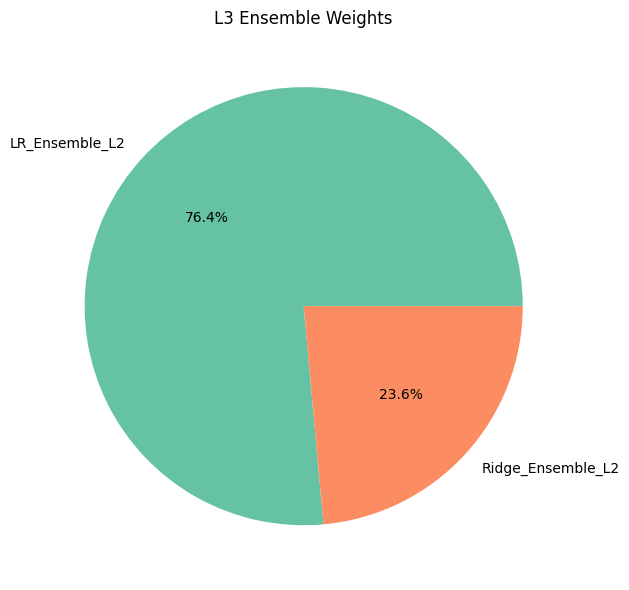

In [23]:
plt.figure(figsize=(10, 6))
plt.pie(study.best_params.values(), labels=study.best_params.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', 2))
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [24]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight

In [25]:
save_submission('weighted-ensemble-l3', weighted_test_preds, np.mean(scores['Weighted_Ensemble_L3']))

,id,loan_status
0,58645,0.997485
1,58646,0.016375
2,58647,0.565767
3,58648,0.012866
4,58649,0.056081


# Results

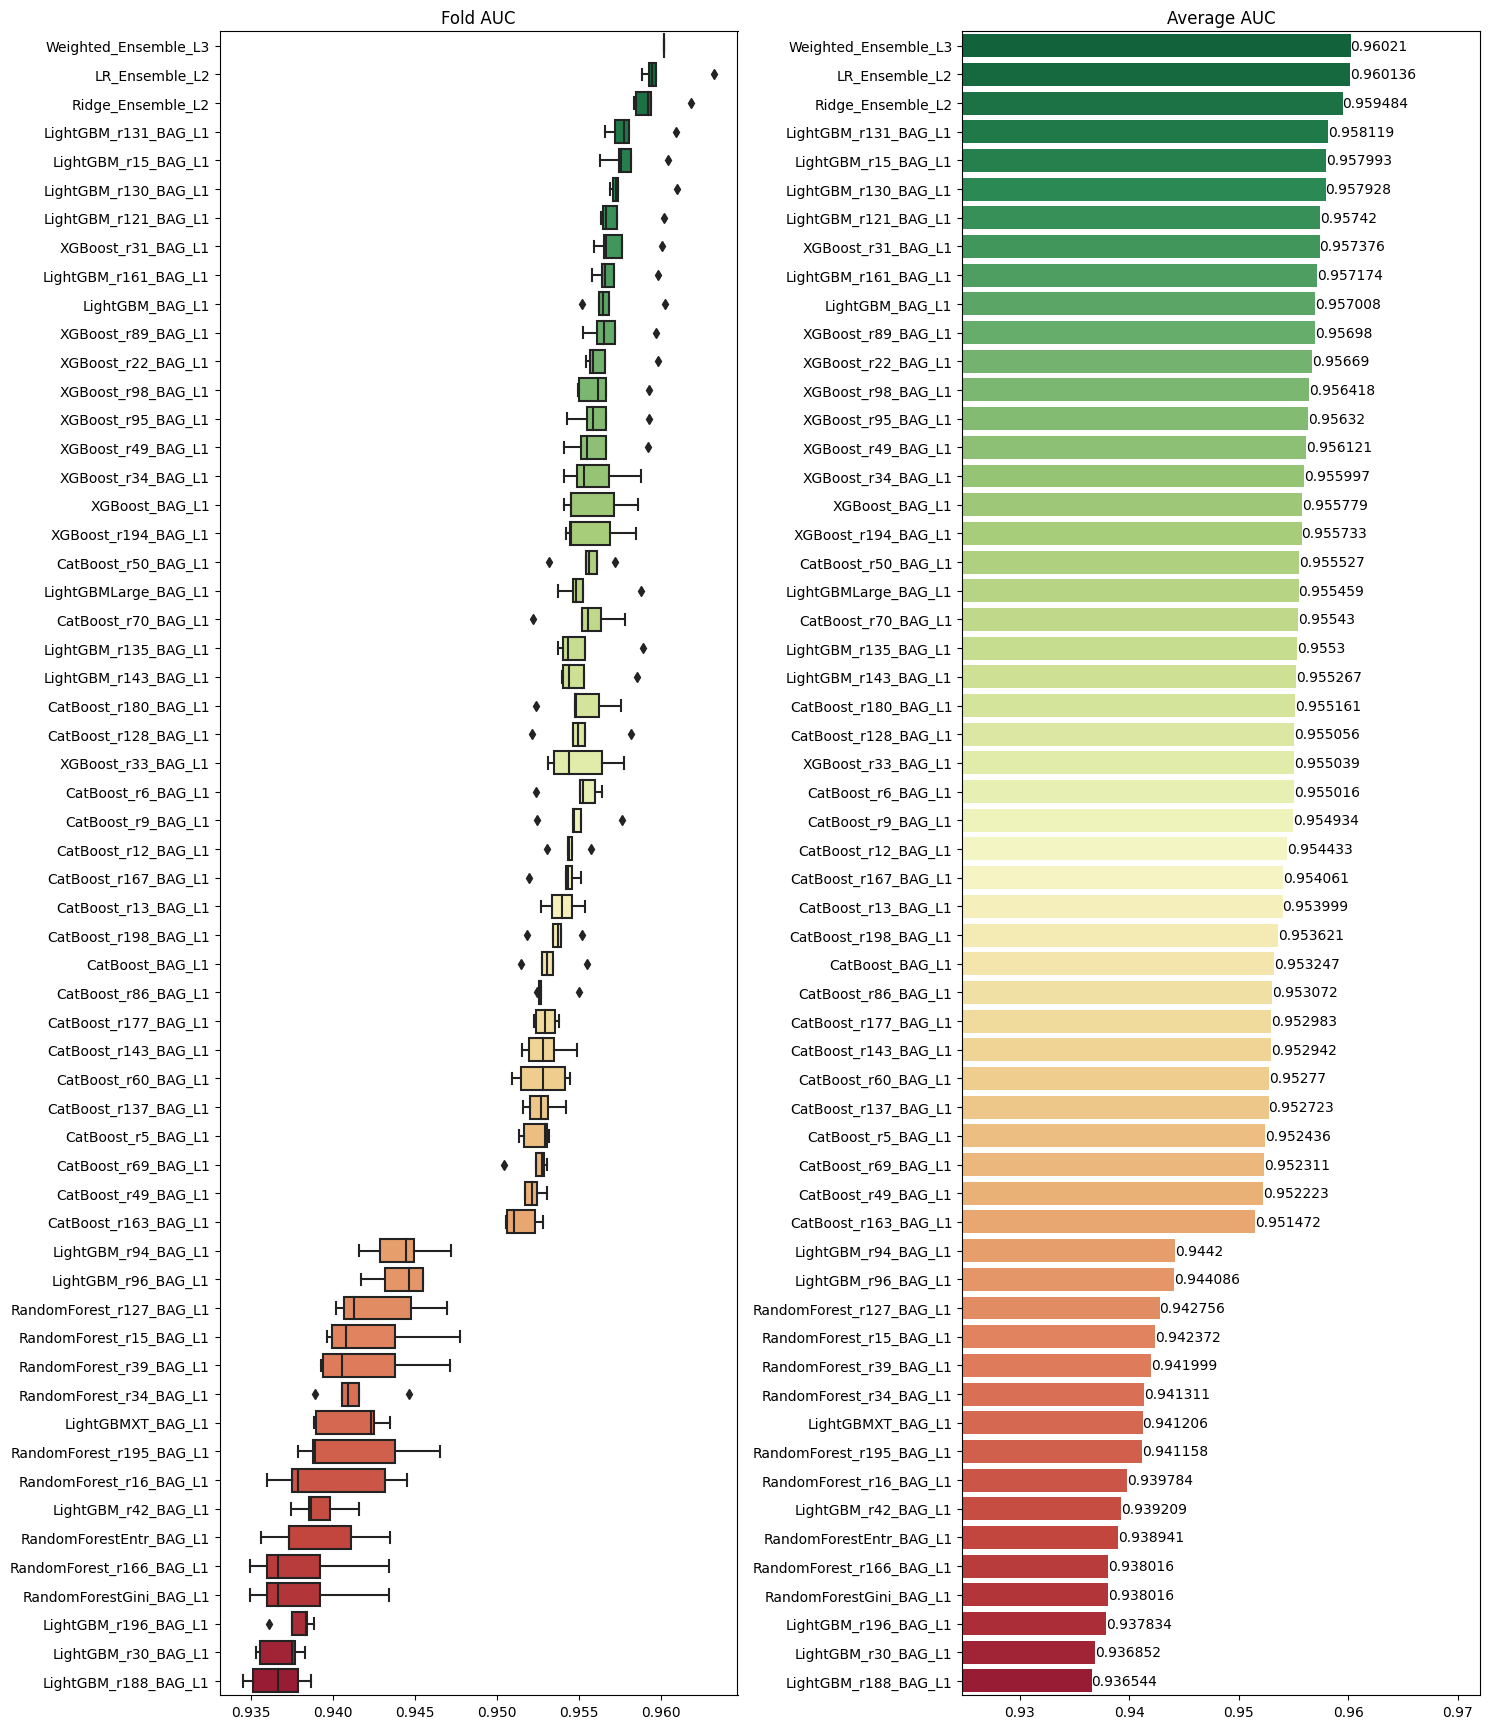

In [26]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()